# E2a: Küchentischversuch zum Laval-Rotor

Name: Junghyun Seo  
Datum:  11.01.2024

## Forschungsfrage

- Wie unterschiedlich wären die Graphen(die Amplitude des Signals als Funktion der Frequenz) eines Lautsprechers und eines Handys? Wird es einen großen/kleinen Unterschied geben?

- Welche Bedeutung hat die Form der Graphen von Amplitude und Frequenz?

# Erster Versuch
Hier werden Sie den ersten Gegenstand auswerten. Die Auswertung des zweiten Gegenstands kann das analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:
![Versuch1](versuch1.jpg)


- Beschreibung des Aufbaus:
Zuerst wurde der Beschleunigungssensor mit dem Raspberry Pi verbunden. Gemäß den Anweisungen wurden GND mit Pin 6, VCC mit Pin 1, SDA mit Pin 3 und SCL mit Pin 5 verbunden. Der Sensor war an einen Lautsprecher befestigt, der Musik mit einer Lautstärke von 52 wiedergibt.


- Vorgangsbeschreibung:
Ein Haarband wurde verwendet, um den Sensor fest am Lautsprecher zu befestigen. Der Lautsprecher wurde über Bluetooth mit einem Laptop verbunden, und die Lautstärke der Musik wurde über den Laptop gesteuert. Die Musik wurde für 20 Sekunden zur Messung abgespielt.

## Versuchsauswertung

Die Vermessung des Haushaltsgegenstands wird in diesem Notebook ausgewertet, dazu werden die drei Funktionen ```get_vec_accel()```, ```interpolation()``` und ```my_fft()``` in ```functions/m_postprocessing.py``` verwendet. Die Ein- und Ausgangsgrößen der Funktionen sind in ```functions/m_postprocessing.py``` definiert, bitte berücksichtigen Sie die vordefinierten Datentypen.


Alle Codeblöcke, in denen Sie Änderungen vornehmen müssen, sind nachfolgend markiert.

In [165]:
import h5py
import numpy as np
import json
import os

%matplotlib inline
import matplotlib.pyplot as plt

from functions.m_operate import evaluate_metadata

from functions.m_postprocessing import get_vec_accel
from functions.m_postprocessing import interpolation
from functions.m_postprocessing import my_fft

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1a. Einlesen der Mess- und Metadaten

In [166]:
"""Parameter definition"""
# -------------------------------------------------------------------------------------------#1-start
# TODO: Adjust the parameters to your needs. Please use relative paths!
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
path_measurement_folder = 'measurement_data/data_20240111_003847_JunghyunSeo_lautsprecher' # replace None by the relative path to the first object's folder
h5_file_name = 'data_20240111_003847_JunghyunSeo_lautsprecher.h5' # replace None by the filename of the hdf5-file
# ---------------------------------------------------------------------------------------------#1-end

In [167]:
"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1eeaf34e-6054-614a-bd63-5cf06bb238d8": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_20240111_003847_JunghyunSeo_lautsprecher/1eeaf34e-6054-614a-bd63-5cf06bb238d8.json"
  },
  "1eeaf383-d28a-6fe7-a756-602f24ffdb22": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240111_003847_JunghyunSeo_lautsprecher/1eeaf383-d28a-6fe7-a756-602f24ffdb22.json"
  },
  "1eeaf353-55b5-6e82-b2eb-c521c869dead": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_20240111_003847_JunghyunSeo_lautsprecher/1eeaf353-55b5-6e82-b2eb-c521c869dead.json"
  },
  "1eeaf380-112a-65b8-84a6-d1b270bcd5e1": {
    "type": "probe",
    "name": "lautsprecher",
    "comment": "",
    "path":

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [168]:
# Define the file path
file_path = 'measurement_data/data_20240111_003847_JunghyunSeo_lautsprecher/data_20240111_003847_JunghyunSeo_lautsprecher.h5'

# Function to find the path of a dataset within an HDF5 file since it was not able to find the keys in h5 file with simple codes
def find_dataset_path(hdf5_file, target_dataset):
    for key in hdf5_file.keys():
        # If the current key is a group, recursively search for the target dataset in the group
        if isinstance(hdf5_file[key], h5py.Group):
            path_in_group = find_dataset_path(hdf5_file[key], target_dataset)
            if path_in_group:
                return key + '/' + path_in_group
        # If the current key is the target dataset, return the key
        elif key == target_dataset:
            return key

# Open the HDF5 file 
with h5py.File(file_path, 'r') as hdf5_file:
    
   
    for key in hdf5_file.keys():
        print(key)
        # If the current key corresponds to a group, print the keys within that group
        if isinstance(hdf5_file[key], h5py.Group):
            for subkey in hdf5_file[key].keys():
                print(f"    {subkey}")

    # Specify the keys that i need from the HDF5 file
    target_datasets = ['timestamp', 'acceleration_x', 'acceleration_y', 'acceleration_z']
    
    # Use the function above to get paths for each keys
    dataset_paths = {dataset: find_dataset_path(hdf5_file, dataset) for dataset in target_datasets}
    
    # Check if all datas were found 
    if all(dataset_paths.values()):
        
        # Extract data from the HDF5 file 
        time_data = np.array(hdf5_file[dataset_paths['timestamp']])
        accel_x_data = np.array(hdf5_file[dataset_paths['acceleration_x']])
        accel_y_data = np.array(hdf5_file[dataset_paths['acceleration_y']])
        accel_z_data = np.array(hdf5_file[dataset_paths['acceleration_z']])
        
    
        print(time_data, accel_x_data, accel_y_data, accel_z_data)
    else:
        
        print("Some datasets not found in the specified path.")

1eeaf353-55b5-6e82-b2eb-c521c869dead
    acceleration_x
    acceleration_y
    acceleration_z
    timestamp
[ 0  0  0 ... 19 19 19] [0.4707192 0.4707192 0.4707192 ... 0.5491724 0.5099458 0.5099458] [-1.2944778 -1.2944778 -1.2944778 ... -1.372931  -1.2552512 -1.2552512] [9.4536106 9.4536106 9.4536106 ... 9.2574776 9.610517  9.610517 ]


#### 2. Betrag der Beschleunigung berechnen

Die Messdaten des Beschleunigungssensors sind vektorielle Werte (```acc_x, acc_y, acc_z```). Berechnen Sie für jeden Zeitpunkt in ```vec_time``` den Betrag des Beschleunigungsvektors. Verwenden Sie dazu die Funktion ```get_vec_accel()```. In den folgenden Aufgaben wird der Betrag der Beschleunigung weiterverwendet.

In [169]:
import numpy as np
from numpy.fft import fft
from typing import Tuple

accel_magnitude = get_vec_accel(accel_x_data, accel_y_data, accel_z_data)


print(accel_magnitude)


[9.55342885 9.55342885 9.55342885 ... 9.37482914 9.70555188 9.70555188]


#### 3. Darstellung der Messdaten
Stellen Sie den Betrag der Beschleunigung über die Zeit und die zeitlichen Abstände zwischen den Messpunkten über die Zeit graphisch dar. Achten Sie dabei auf eine sinnvolle Achsenbeschriftung. 

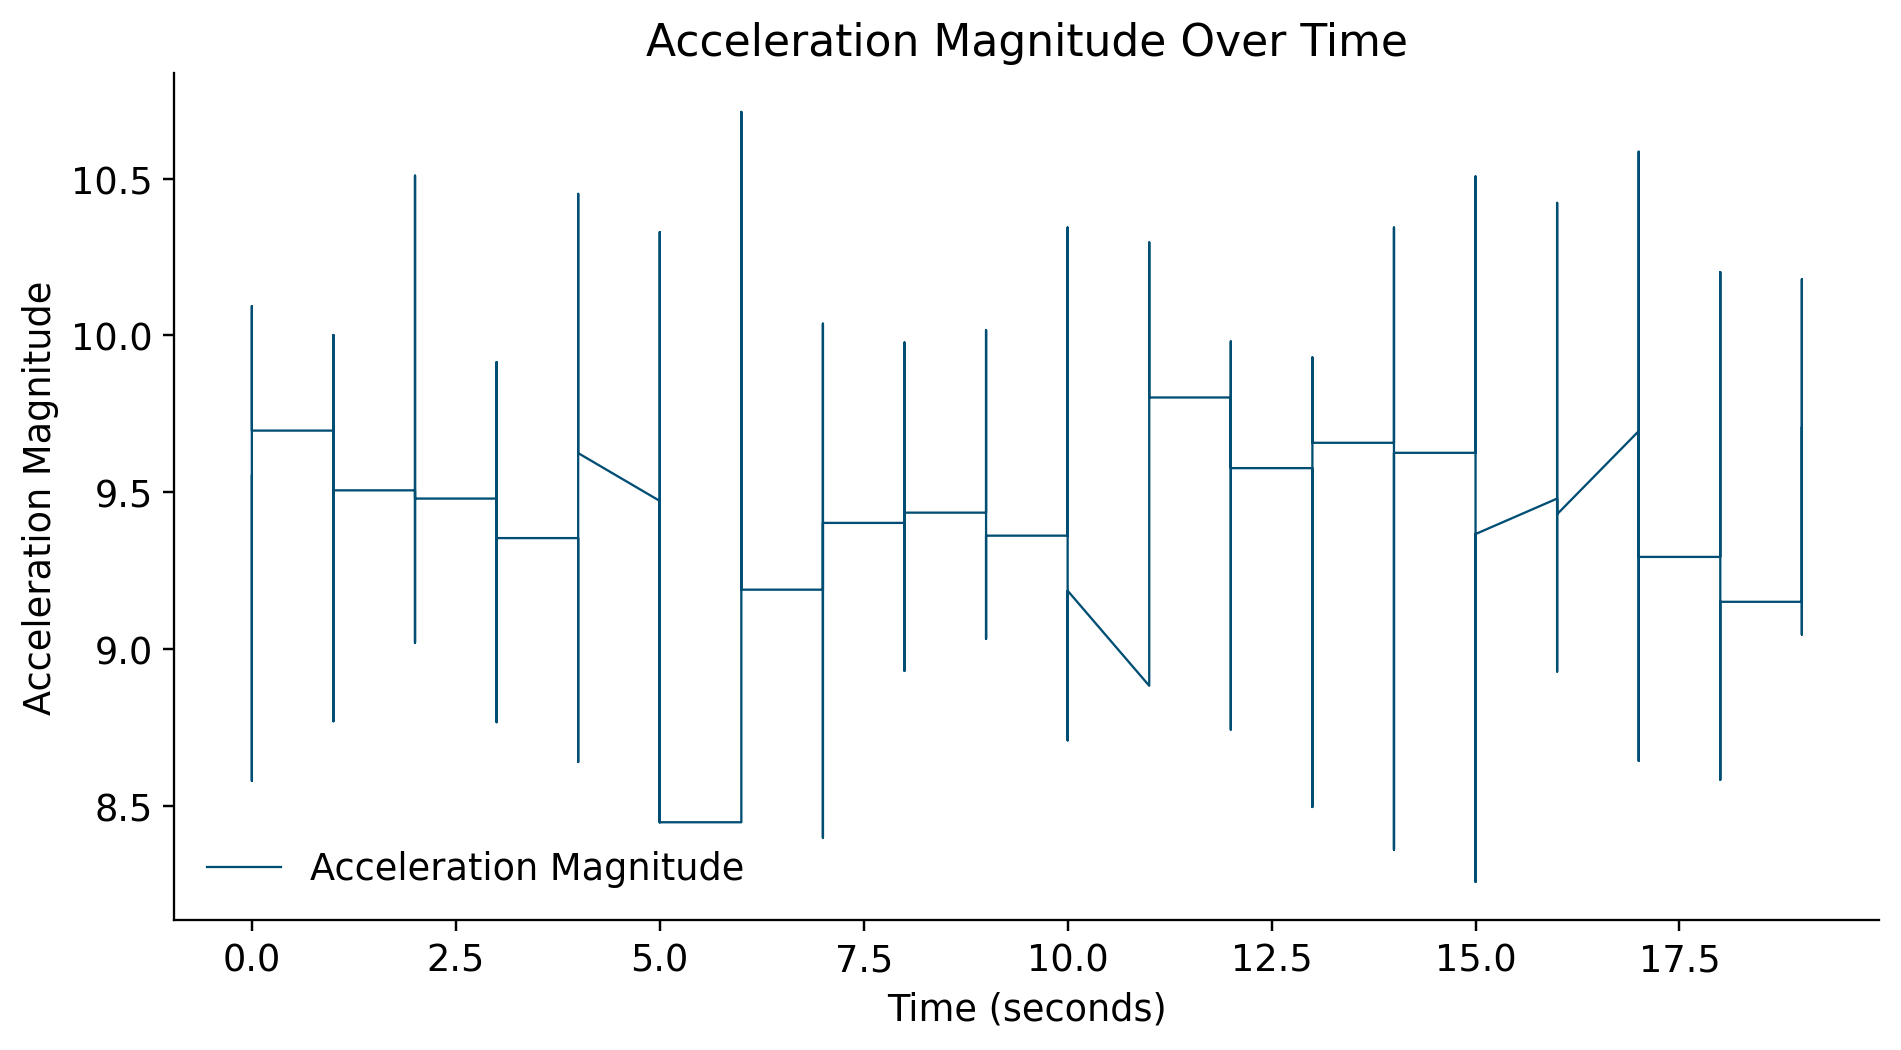

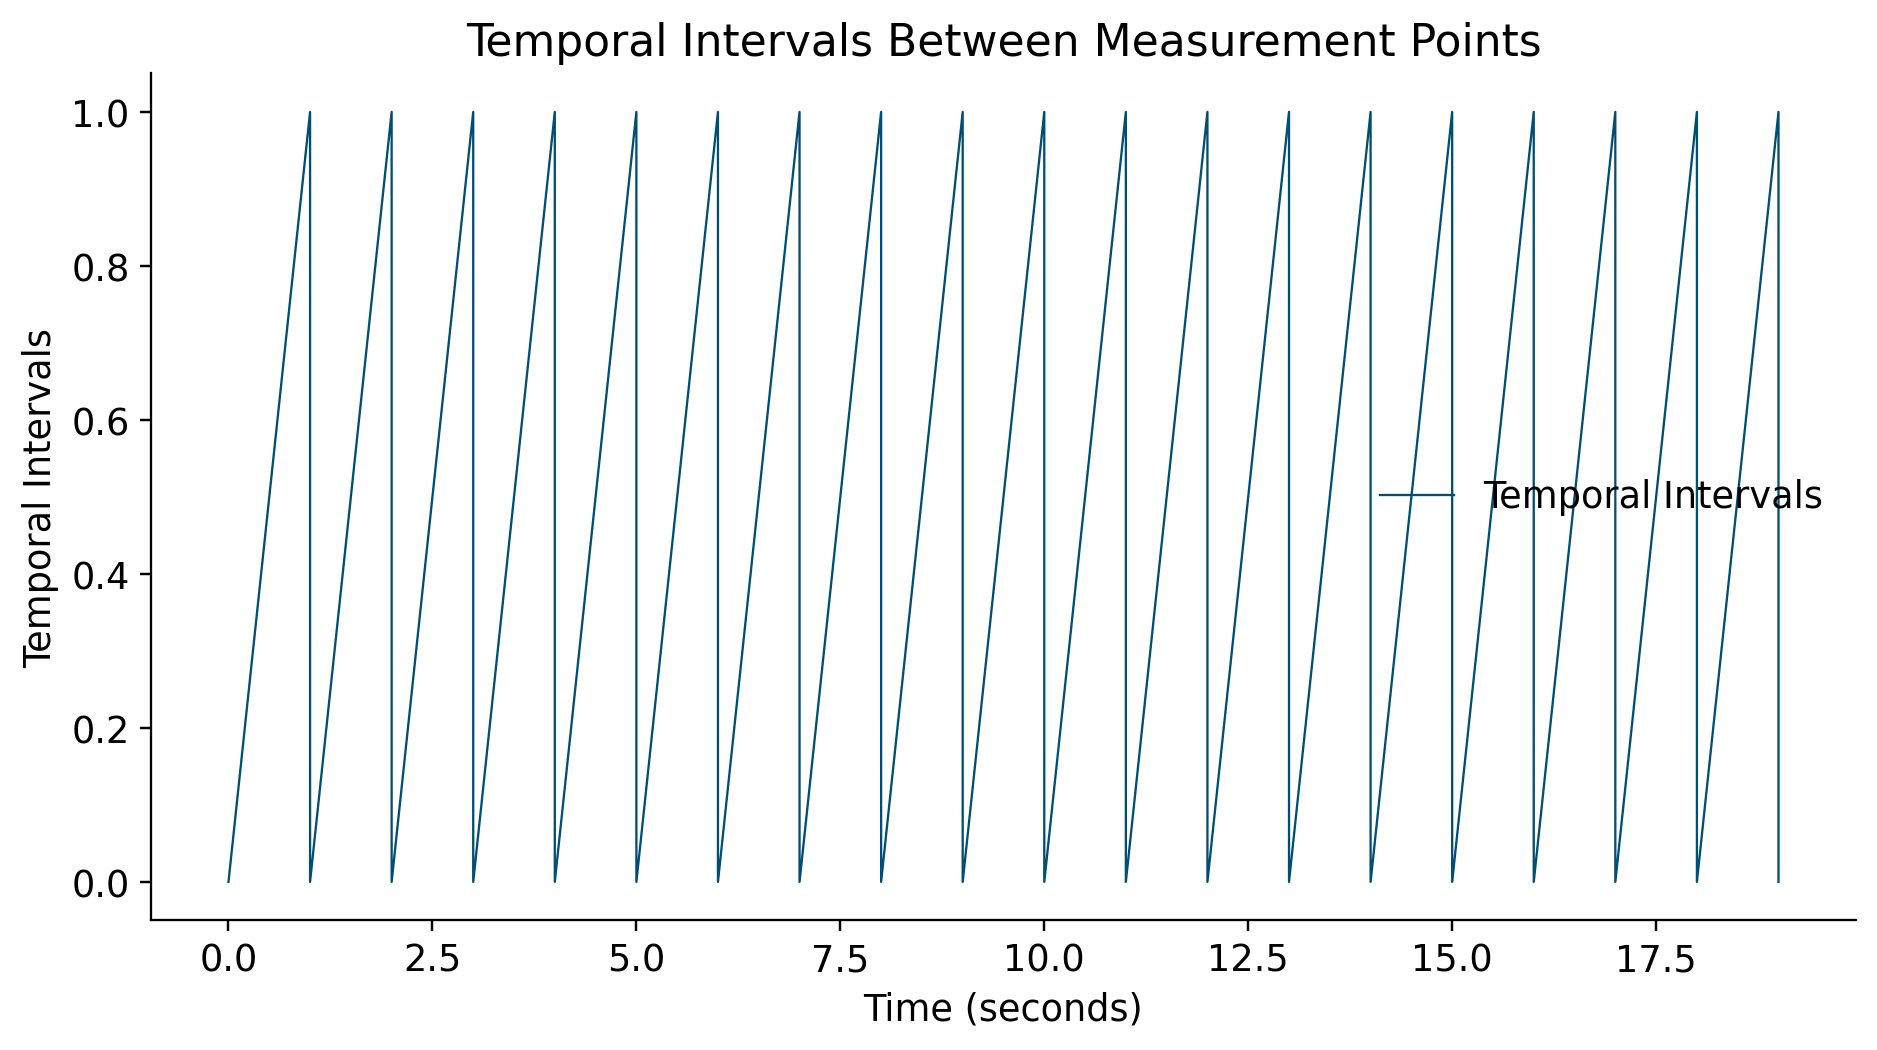

In [170]:
import numpy as np
import matplotlib.pyplot as plt

# Plotting acceleration magnitude over time
plt.figure(figsize=(10, 5))
plt.plot(time_data, accel_magnitude, label='Acceleration Magnitude')
plt.xlabel('Time (seconds)')
plt.ylabel('Acceleration Magnitude')
plt.title('Acceleration Magnitude Over Time')
plt.legend()
plt.show()


# Calculating temporal intervals
time_intervals = np.diff(time_data)
# Plotting temporal intervals over time
plt.figure(figsize=(10, 5))
plt.plot(time_data[1:], time_intervals, label='Temporal Intervals')
plt.xlabel('Time (seconds)')
plt.ylabel('Temporal Intervals')
plt.title('Temporal Intervals Between Measurement Points')
plt.legend()
plt.show()



#### 4. Interpolation der Messwerte

Da es sich beim Pi nicht um ein Echtzeit-Messsystem handelt, variieren die Zeitabstände zwischen den Messwerten. Da für die FFT äquidistante Messwerte benötigt werden, ist eine Interpolation der Daten erforderlich.

In [171]:
# -------------------------------------------------------------------------------------------#4-start
# TODO: Write the function interpolation() (in m_postprocessing) to linearly interpolate the
# acceleration.


interpolation_points, interpolated_values = interpolation(time_data, accel_magnitude)

print("Interpolation Points:", interpolation_points)
print("Interpolated Values:", interpolated_values)


Interpolation Points: [0.00000000e+00 1.16700448e-03 2.33400897e-03 ... 1.89976660e+01
 1.89988330e+01 1.90000000e+01]
Interpolated Values: [9.69674887 9.69674887 9.69674887 ... 9.15090245 9.15090245 9.70555188]


#### 5 & 6. FFT durchführen und graphisch darstellen

Transformieren Sie die interpolierten Beträge der Beschleunigung mit der Funktion ```my_fft()``` in den Frequenzraum. Eine Skalierung der Amplitude der FFT ist nicht notwendig.
Stellen Sie die Amplitude des Signals als Funktion der Frequenz graphisch dar.

[6.67008692e-12 1.42886645e+03 1.07498695e+03 ... 1.19912505e+00
 9.21799585e-01 1.29646612e+00] [0.00000000e+00 5.26283464e-02 1.05256693e-01 ... 4.28289483e+02
 4.28342112e+02 4.28394740e+02]


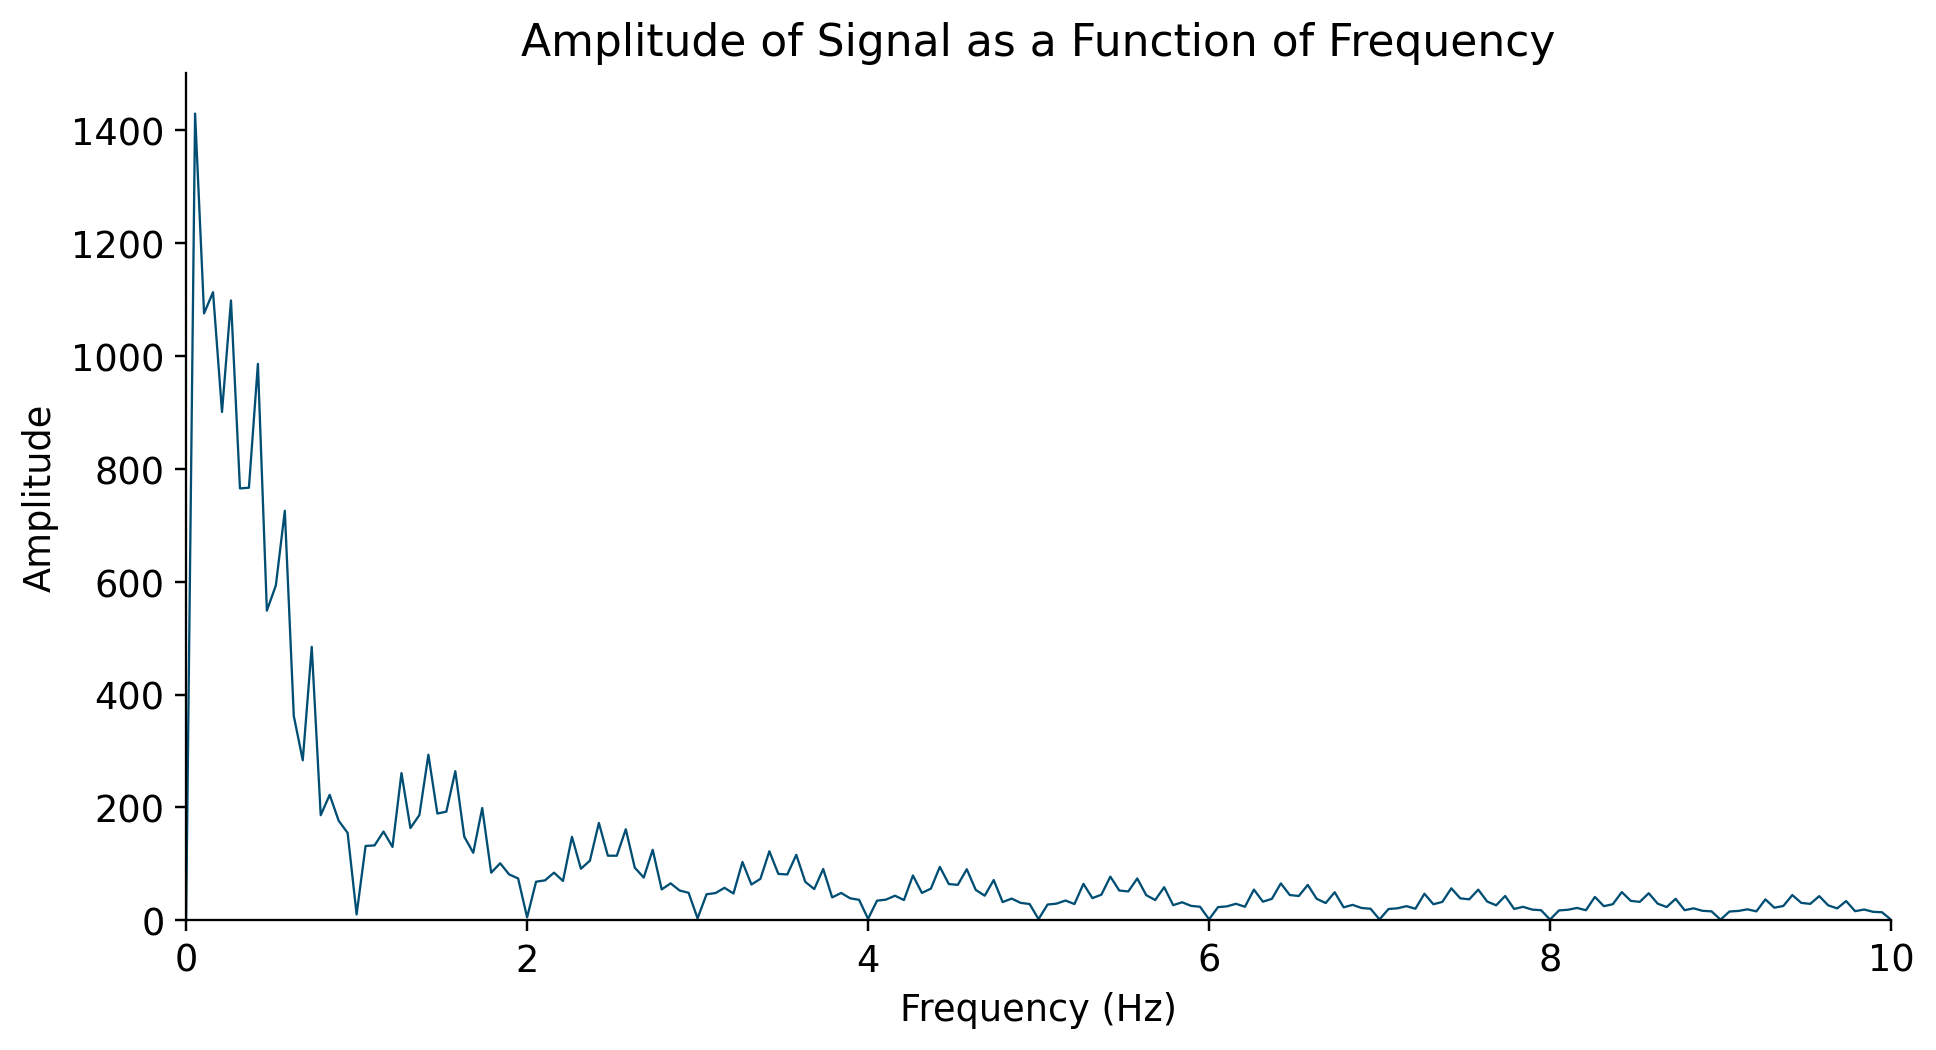

In [172]:
# -------------------------------------------------------------------------------------------#5-start
# TODO: Write my_fft() (in m_postprocessing) and plot results.
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# Assuming interpolation_points and interpolated_values are obtained from the interpolation function
interpolation_points, interpolated_values = interpolation(time_data, accel_magnitude)

# Perform FFT on the interpolated data using the module
fft_amplitude, fft_frequency = my_fft(interpolated_values, interpolation_points)

# Print or use the resulting FFT amplitude and frequency values
print(fft_amplitude, fft_frequency)

import matplotlib.pyplot as plt

# Plotting the amplitude as a function of frequency
plt.figure(figsize=(10, 5))
plt.plot(fft_frequency, fft_amplitude)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, 10) 
plt.ylim(0,1500)
plt.title('Amplitude of Signal as a Function of Frequency')
plt.show()

# Zweiter Versuch
Hier werten Sie den zweiten Gegenstand aus.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:
![versuch2](versuch2.jpg)

- Beschreibung des Aufbaus:
Hier wurde auch der Beschleunigungssensor mit dem Raspberry Pi verbunden. Gemäß den Anweisungen wurden GND mit Pin 6, VCC mit Pin 1, SDA mit Pin 3 und SCL mit Pin 5 verbunden. Der Sensor war an einem Handy befestigt, das vibriert.


- Vorgangsbeschreibung:
Ein Haarband wurde verwendet, um den Sensor fest am Handy zu befestigen. Ein Vibrationsalarm wurde für die Messung verwendet, und er vibrierte für 20 Sekunden.

## Versuchsauswertung

Führen Sie die obige Auswertung für den zweiten Gegenstand durch. Sie brauchen dafür nichts neu zu implementieren.

#### 1a. Einlesen der Mess- und Metadaten

In [173]:
path_measurement_folder = 'measurement_data/data_20240110_114809_JunghyunSeo_handy' # replace None by the relative path to the first object's folder
h5_file_name = 'data_20240110_114809_JunghyunSeo_handy.h5'

"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1eeaf34e-6054-614a-bd63-5cf06bb238d8": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_20240110_114809_JunghyunSeo_handy/1eeaf34e-6054-614a-bd63-5cf06bb238d8.json"
  },
  "1eeaf383-d28a-6fe7-a756-602f24ffdb22": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240110_114809_JunghyunSeo_handy/1eeaf383-d28a-6fe7-a756-602f24ffdb22.json"
  },
  "1eeaf353-55b5-6e82-b2eb-c521c869dead": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_20240110_114809_JunghyunSeo_handy/1eeaf353-55b5-6e82-b2eb-c521c869dead.json"
  },
  "1eeafa4f-b582-6f84-8ae9-08174756461d": {
    "type": "probe",
    "name": "handy",
    "comment": "",
    "path": "measurement_data/data_2024

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [174]:
# Define the file path
file_path = 'measurement_data/data_20240110_114809_JunghyunSeo_handy/data_20240110_114809_JunghyunSeo_handy.h5'

# Function to find the path of a dataset within an HDF5 file since it was not able to find the keys in h5 file with simple codes
def find_dataset_path(hdf5_file, target_dataset):
    for key in hdf5_file.keys():
        # If the current key is a group, recursively search for the target dataset in the group
        if isinstance(hdf5_file[key], h5py.Group):
            path_in_group = find_dataset_path(hdf5_file[key], target_dataset)
            if path_in_group:
                return key + '/' + path_in_group
        # If the current key is the target dataset, return the key
        elif key == target_dataset:
            return key

# Open the HDF5 file 
with h5py.File(file_path, 'r') as hdf5_file:
    
   
    for key in hdf5_file.keys():
        print(key)
        # If the current key corresponds to a group, print the keys within that group
        if isinstance(hdf5_file[key], h5py.Group):
            for subkey in hdf5_file[key].keys():
                print(f"    {subkey}")

    # Specify the keys that i need from the HDF5 file
    target_datasets = ['timestamp', 'acceleration_x', 'acceleration_y', 'acceleration_z']
    
    # Use the function above to get paths for each keys
    dataset_paths = {dataset: find_dataset_path(hdf5_file, dataset) for dataset in target_datasets}
    
    # Check if all datas were found 
    if all(dataset_paths.values()):
        
        # Extract data from the HDF5 file 
        time_data = np.array(hdf5_file[dataset_paths['timestamp']])
        accel_x_data = np.array(hdf5_file[dataset_paths['acceleration_x']])
        accel_y_data = np.array(hdf5_file[dataset_paths['acceleration_y']])
        accel_z_data = np.array(hdf5_file[dataset_paths['acceleration_z']])
        
    
        print(time_data, accel_x_data, accel_y_data, accel_z_data)
    else:
        
        print("Some datasets not found in the specified path.")

1eeaf353-55b5-6e82-b2eb-c521c869dead
    acceleration_x
    acceleration_y
    acceleration_z
    timestamp
[ 0  0  0 ... 19 19 19] [0.2353596 0.2353596 0.2353596 ... 0.392266  0.392266  0.392266 ] [-1.2944778 -1.2944778 -1.2944778 ... -1.176798  -1.176798  -1.1375714] [9.3359308 9.3359308 9.3359308 ... 9.2967042 9.2967042 9.2967042]


#### 2. Betrag der Beschleunigung berechnen


In [175]:
import numpy as np
from numpy.fft import fft
from typing import Tuple


accel_magnitude = get_vec_accel(accel_x_data, accel_y_data, accel_z_data)


print(accel_magnitude)

[9.42818492 9.42818492 9.42818492 ... 9.37909565 9.37909565 9.37425465]


#### 3. Darstellung der Messdaten

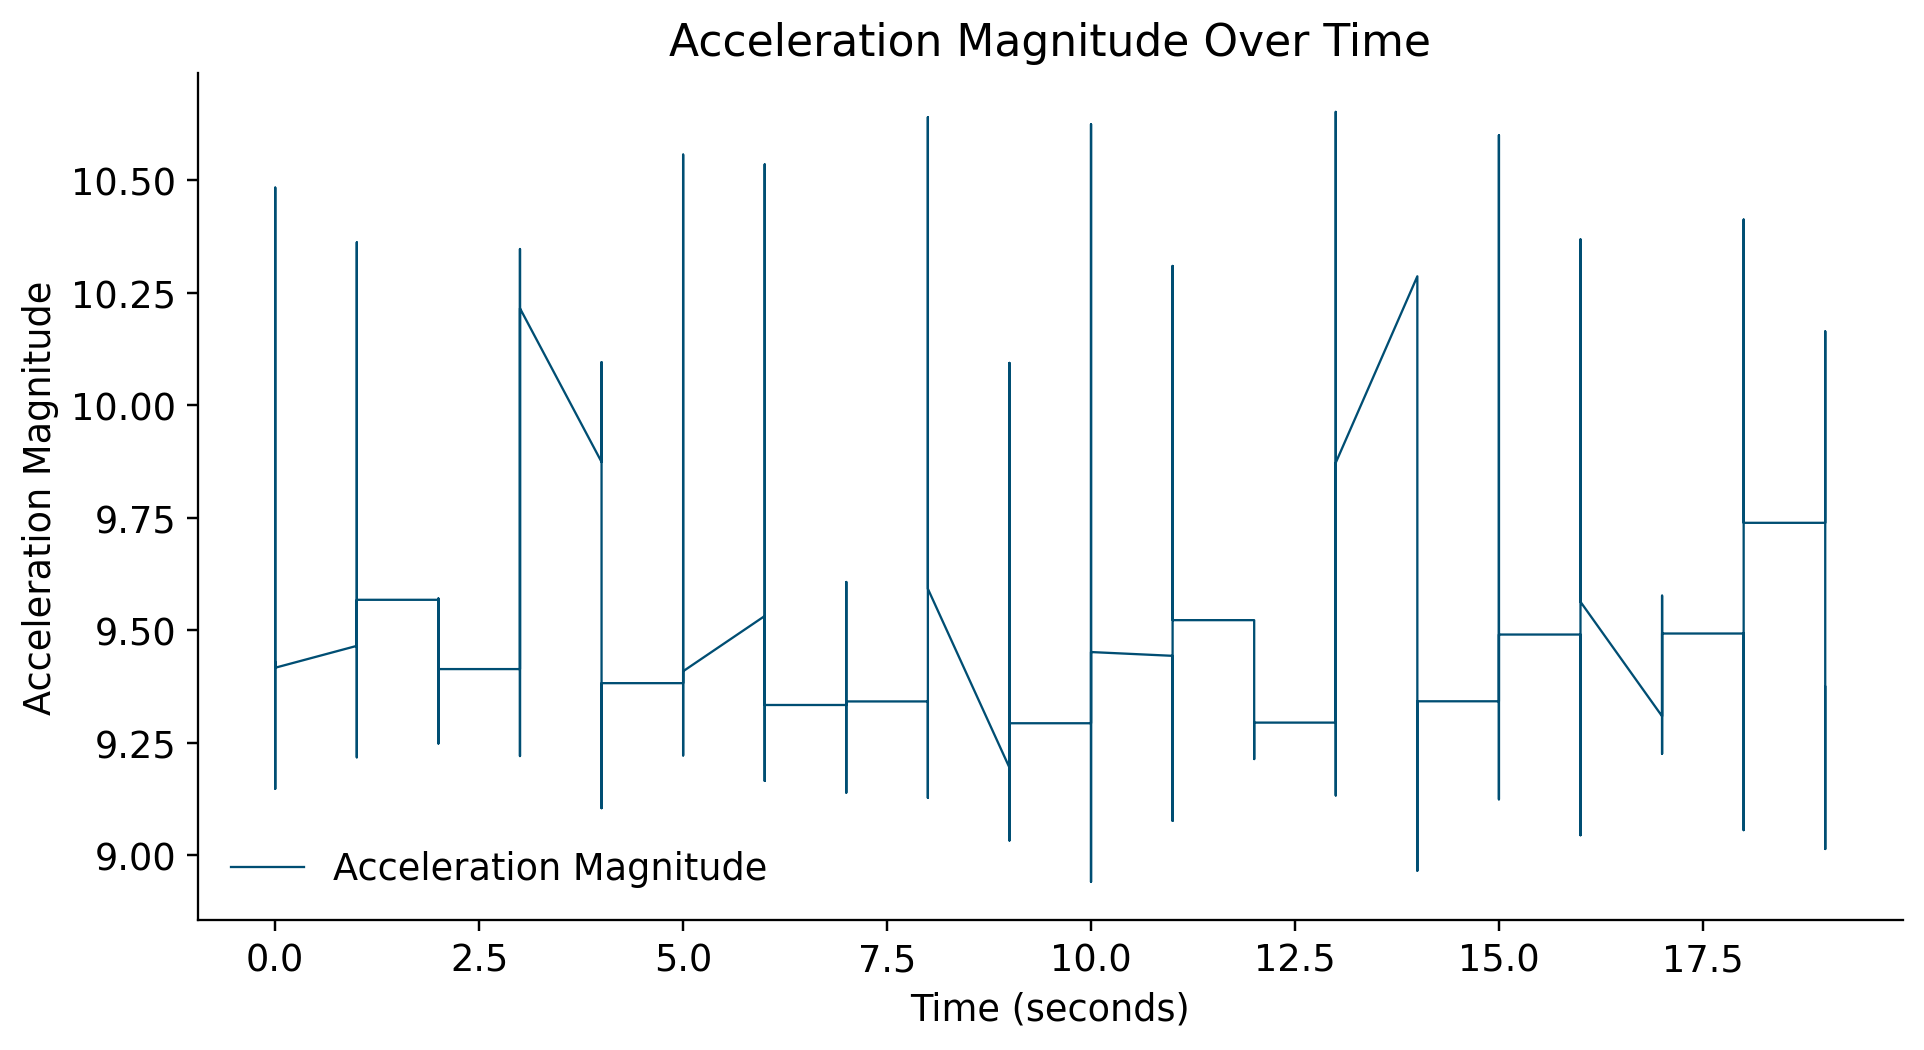

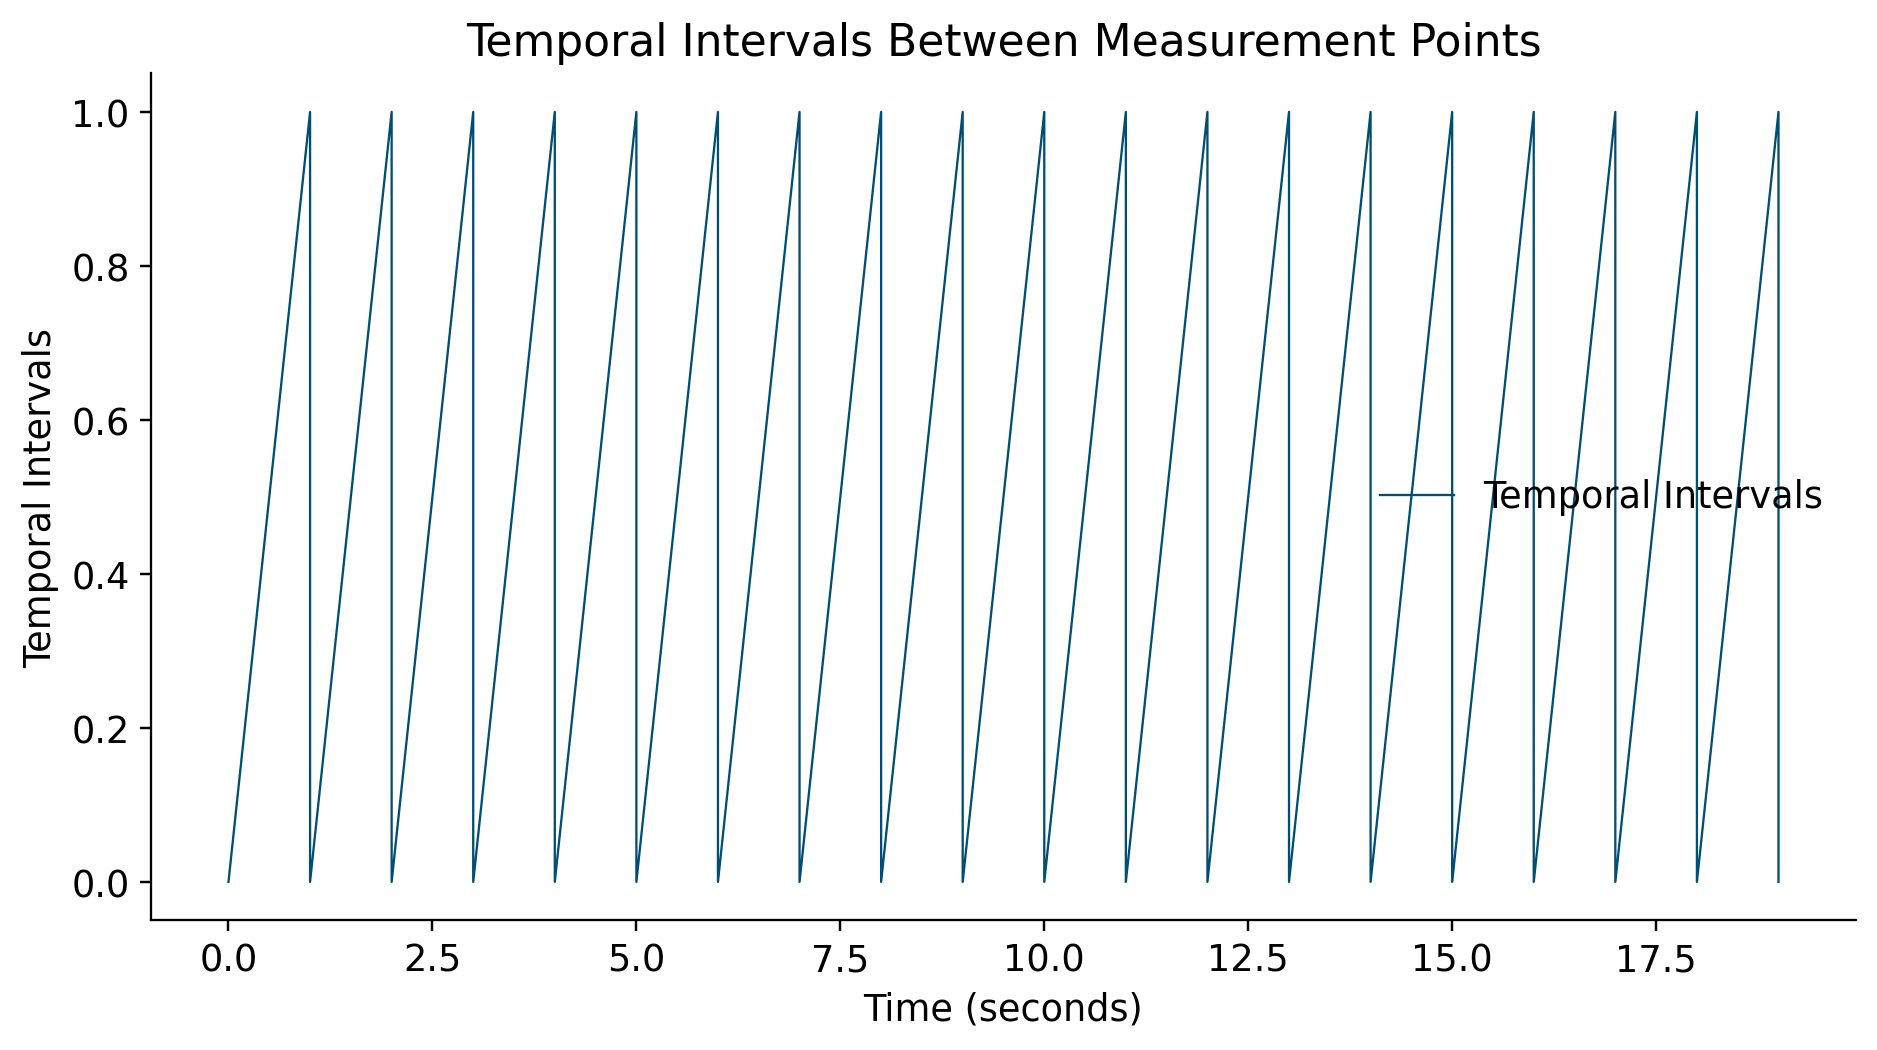

In [176]:
# Plotting acceleration magnitude over time
plt.figure(figsize=(10, 5))
plt.plot(time_data, accel_magnitude, label='Acceleration Magnitude')
plt.xlabel('Time (seconds)')
plt.ylabel('Acceleration Magnitude')
plt.title('Acceleration Magnitude Over Time')
plt.legend()
plt.show()


# Calculating temporal intervals
time_intervals = np.diff(time_data)
# Plotting temporal intervals over time
plt.figure(figsize=(10, 5))
plt.plot(time_data[1:], time_intervals, label='Temporal Intervals')
plt.xlabel('Time (seconds)')
plt.ylabel('Temporal Intervals')
plt.title('Temporal Intervals Between Measurement Points')
plt.legend()
plt.show()

#### 4. Interpolation der Messwerte



In [177]:

interpolation_points, interpolated_values = interpolation(time_data, accel_magnitude)

print("Interpolation Points:", interpolation_points)
print("Interpolated Values:", interpolated_values)


Interpolation Points: [0.00000000e+00 1.09909180e-03 2.19818361e-03 ... 1.89978018e+01
 1.89989009e+01 1.90000000e+01]
Interpolated Values: [9.41683534 9.41688872 9.41694211 ... 9.73878854 9.73878854 9.37425465]


#### 5 & 6. FFT durchführen und graphisch darstellen


[8.35609855e-12 7.99964312e+02 8.87044078e+02 ... 4.82350698e-01
 5.54458580e-01 7.46572128e-01] [0.00000000e+00 5.26285345e-02 1.05257069e-01 ... 4.54763167e+02
 4.54815796e+02 4.54868424e+02]


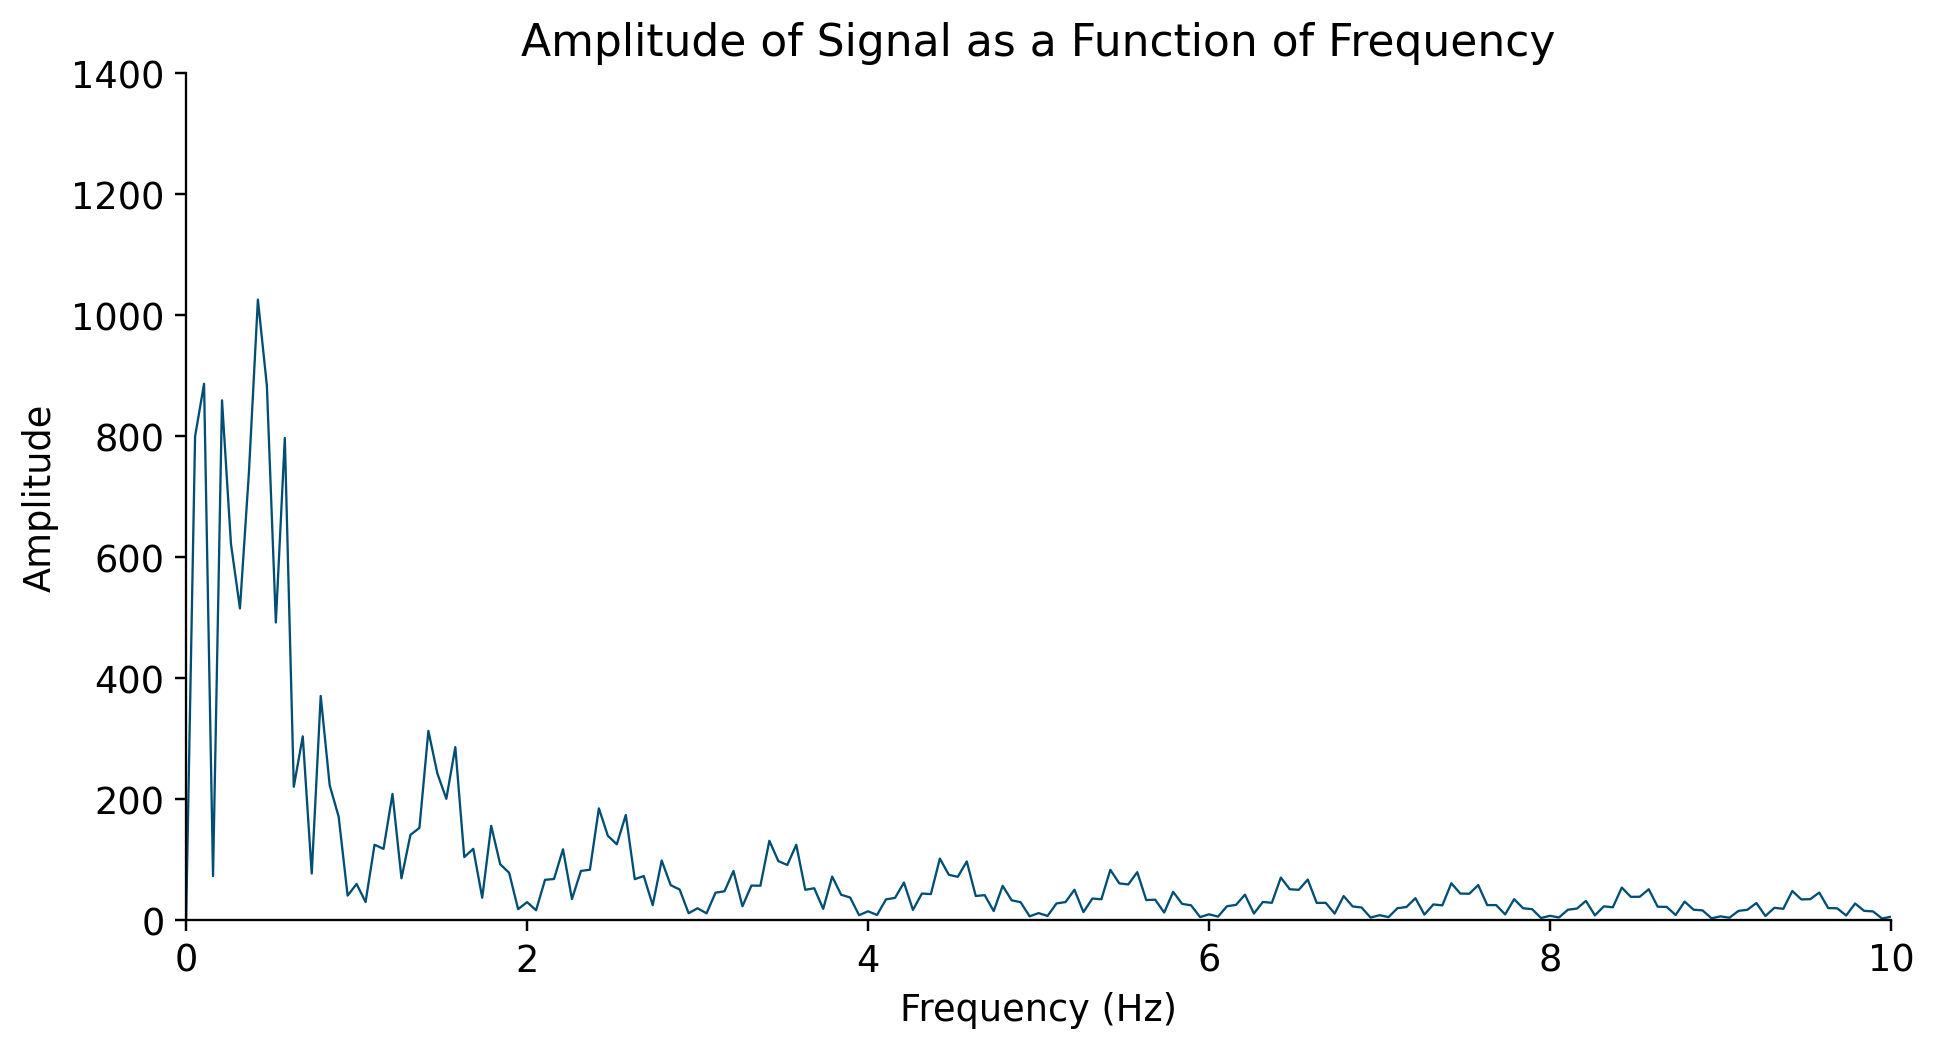

In [178]:

# Assuming interpolation_points and interpolated_values are obtained from the interpolation function
interpolation_points, interpolated_values = interpolation(time_data, accel_magnitude)

# Perform FFT on the interpolated data using the module
fft_amplitude, fft_frequency = my_fft(interpolated_values, interpolation_points)

# Print or use the resulting FFT amplitude and frequency values
print(fft_amplitude, fft_frequency)

import matplotlib.pyplot as plt

# Plotting the amplitude as a function of frequency
plt.figure(figsize=(10, 5))
plt.plot(fft_frequency, fft_amplitude)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, 10) 
plt.ylim(0,1400)
plt.title('Amplitude of Signal as a Function of Frequency')
plt.show()

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

- Wie unterschiedlich wären die Graphen(die Amplitude des Signals als Funktion der Frequenz) eines Lautsprechers und eines Handys? Wird es einen großen/kleinen Unterschied geben?

Wie aus dem Diagramm des Lautsprechers und des Handys ersichtlich ist, haben sie eine ähnliche Form. Die Grade der Amplitude sind ebenfalls recht ähnlich, was darauf hinweist, dass sie ähnliche Klangmerkmale haben. Beide Geräte können problemlos austauschbar verwendet werden, beispeisweise zum Musikhören, ohne größere Unannehmlichkeiten.

- Welche Bedeutung hat die Form der Graphen von Amplitude und Frequenz?
 
Das Diagramm zeigt, wie ein System auf verschiedene Frequenzen reagiert. Beide Diagramme zeigen, dass die Amplituden bei niedrigen Frequenzen (z.B. 0-2Hz) sehr hoch sind und dann mit zunehmender Frequenz signifikant abnehmen. Dies deutet darauf hin, dass das System eine stärkere Reaktion auf Signale mit niedriger Frequenz aufweist. 
Ein Unterschied, der aus den Graphen ersichtlich war, ist, dass der Lautsprecher eine deutlicherer Präsenz von niederfrequenten Komponenten im Signal aufweist. 
Die Annahme, warum die beiden Diagramme sehr ähnlich sind, könnte sein, dass die Vibrationen des Handys niedrige Frequenzen aufweisen und die Lautstärke der Musik vom Lautsprehcer nicht laut genug war, um deutliche Unterschiede von der Vibration zu erzeugen. 


## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Mit Fourier-Analyse kann die Amplitude eines Signals in Abhängigkeit von der Frequenz analysiert werden. Die Beschleunigungsdaten aus dem Zeitbereich wurden durch die Fourier-Transformation in den Frequenzbereich überführt. Dadurch konnte festgestellt werden, wie viel von jeder Frequenz im Originalsignal vorhanden ist. 

Außerdem denke ich, dass es für den Bericht besser gewesen wäre, wenn ich größere Maschinen wie Waschmaschinen hätte messen können, um einen deutlicheren Unterschied zu sehen. Es war jedoch auch gut zu erfahren, was eine ähnliche Beziehung zwischen Amplitude und Frequenz bedeutet und wie sie im täglichen Leben angewendet werden kann.